In [9]:
from torch import softmax, sqrt, tensor, topk


def gather(t, dim, i):
    dim += (dim < 0) * t.ndim
    return t.gather(dim, i.expand(*t.shape[:dim], i.shape[dim], *t.shape[dim + 1 :]))


def reshape_kv(*xs, n_kv_heads):
    # Reshape tensors to (batch_size, n_kv_heads, n_heads_per_kv, *)
    return [x.unflatten(dim=1, sizes=(n_kv_heads, -1)) for x in xs]


def attn(Q, K, V, M):
    Q, K, V, M = reshape_kv(Q, K, V, M, n_kv_heads=K.shape[1])
    
    s = (Q @ K.transpose(-1, -2)) / sqrt(tensor(Q.shape[-1])) + M
    y = softmax(s, dim=-1) @ V
    return y.flatten(start_dim=1, end_dim=2)


def sparq_attn(Q, K, V, V_mean, M, r, k):
    Q, K, V, V_mean, M = reshape_kv(Q, K, V, V_mean, M, n_kv_heads=K.shape[1])

    # 1. Approximate attention scores using r largest components of Q
    i1 = topk(abs(Q).sum(dim=2, keepdim=True), r, -1).indices
    Q_hat, K_hat = gather(Q, -1, i1), gather(K, -1, i1)
    scale = sqrt(
        Q.shape[-1]
        * abs(Q_hat).sum(dim=-1, keepdim=True)
        / abs(Q).sum(dim=-1, keepdim=True)
    )
    s_hat = softmax(Q_hat @ K_hat.transpose(-1, -2) / scale + M, dim=-1)

    # 2. Gather top k positions based on approximate attention scores & run attention
    i2 = topk(s_hat.sum(dim=2, keepdim=True), k, -1).indices
    iKV = i2[..., 0, :, None]
    K, V, M = gather(K, -2, iKV), gather(V, -2, iKV), gather(M, -1, i2)
    y_ = attn(Q, K, V, M)

    # 3. Estimate the total score of the top k, and interpolate with V_mean
    alpha = gather(s_hat, -1, i2).sum(-1, keepdim=True)
    y = alpha * y_ + (1 - alpha) * V_mean
    return y.flatten(start_dim=1, end_dim=2)

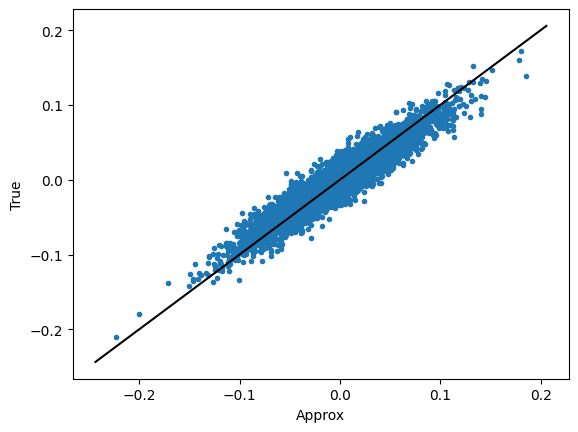

In [10]:
from torch import rand, randn
import matplotlib.pyplot as plt

batch_size, n_head, context_size, head_size = 5, 16, 2048, 64
n_kv_head = 8
k, rank = 512, 32
mask_rate = 0.25

Q = randn(batch_size, n_head, 1, head_size)
K = randn(batch_size, n_kv_head, context_size, head_size)
V = randn(batch_size, n_kv_head, context_size, head_size)
M = -1e9 * (rand(batch_size, n_head, 1, context_size) < mask_rate)

original = attn(Q, K, V, M)
approx = sparq_attn(Q, K, V, V.mean(-2, keepdim=True), M, r=rank, k=k)

plt.plot(approx.flatten(), original.flatten(), '.')
xlim = plt.xlim()
plt.plot(xlim, xlim, "k-")
plt.ylabel("True")
plt.xlabel("Approx")
plt.show()